# 17. 설명변수가 있는 계층적 정규회귀 모형

In [4]:
library(bayesrules)
library(tidyverse)
library(rstanarm)
library(bayesplot)
library(tidybayes)
library(broom.mixed)

In [5]:
data(cherry_blossom_sample)
running <- cherry_blossom_sample

running <- running %>% 
  select(runner, age, net) %>% 
  na.omit()

<br>

## 17.01. 완전 풀링

In [ ]:
complete_pooled_model <- stan_glm(
  net ~ age, 
  data = running, family = gaussian, 
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

In [7]:
prior_summary(complete_pooled_model)

Priors for model 'complete_pooled_model' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 35)

Coefficients
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 15)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.072)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{split}
Y_{ij} | \beta_0, \beta_1, \sigma & \sim N(\mu_i, \sigma^2) \;\; \text{ where } \mu_i = \beta_0 + \beta_1 X_{ij} \\
\beta_{0c} & \sim N(0, 35^2) \\
\beta_1 & \sim N(0, 15^2) \\
\sigma  & \sim \text{Exp}(0.072) \\
\end{split}
\end{equation}$$

<br>

#### 각 매개변수별 ($\beta_0, \beta_1$) 사후분포 추정량

In [10]:
model_summary <- tidy(complete_pooled_model, 
                      conf.int = TRUE, conf.level = 0.80)
model_summary

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),75.1999496,24.6161022,43.6805427,106.4566330
age,0.2679488,0.4461854,-0.3017243,0.8417984


#### 사후분포 추정량을 통한 회귀선

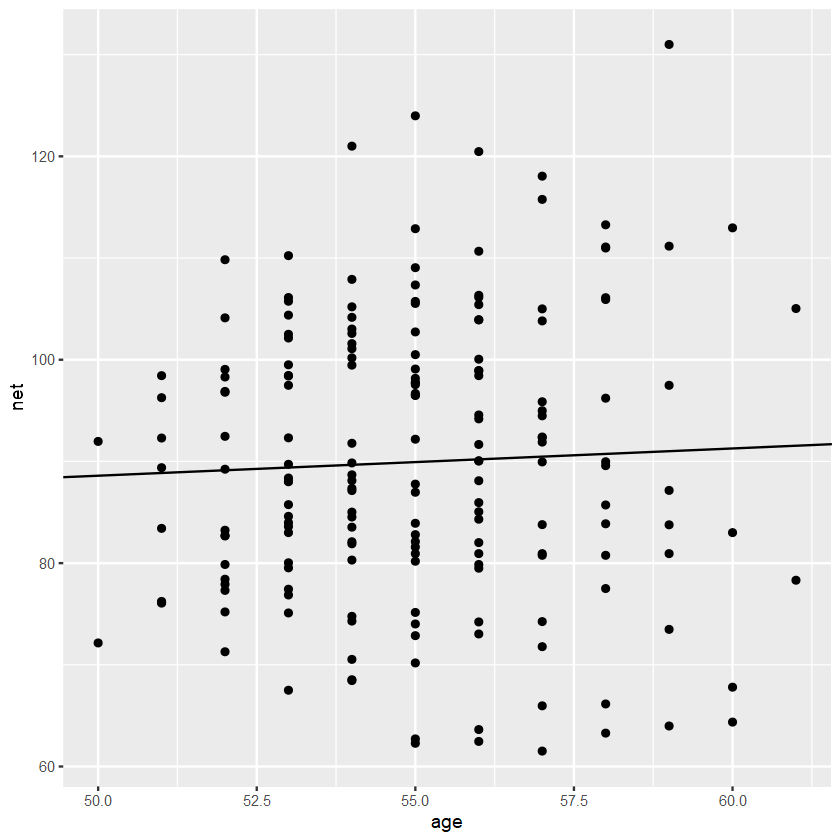

In [11]:
B0 <- model_summary$estimate[1]
B1 <- model_summary$estimate[2]
ggplot(running, aes(x = age, y = net)) + 
  geom_point() + 
  geom_abline(aes(intercept = B0, slope = B1))

<br>

## 17.02. 절편에 대한 계층적 모형

### 계층적 정규회귀모형에 대한 가정
> $Y_{ij}$와 $X_{ij}$가 $j$번째 그룹의 $i$번쨰 관측값이라고 할 때,
> 
> $X_{ij}$를 설명변수, $Y_{ij}$를 반응변수로 가지는 정규회귀모형은 아래의 가정들을 가짐

> 1. 다른 그룹간 관측값들은 서로 독립이지만, 같은 그룹내 관측값들은 상관관계를 가짐
>
> 2. 그룹을 불문하고 $Y_{ij}$ ($\mu_{ij}$)는 $X_{ij}$와 선형관계를 가짐
>
> 3. 그룹을 불문하고, 특정 그룹의 $Y_{ij}$은 그룹내 관측값 평균 $\mu_{ij}$와 그룹내 관측값 표준편차 $\sigma_{ij}$를 매개변수로 가지는 각 그룹별 정규분포를 따름
>
> 4. 그룹별 회귀모형의 절편 $\beta_{0j}$는, 전역 회귀모형 절편 추정량 $\beta_{0}$을 평균으로 가지고, 전역 회귀모형 절편 추정량 표준오차 $\sigma_{0}$를 표준편차로 가지는 정규분포를 따름
    - 완전풀링 모형은 $\sigma_{0}=0$인 특별한 형태

<br>

#### 따라서, 위 데이터에 대하여
$$\begin{equation}
\begin{array}{rll}
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_1 X_{ij} & \text{(그룹별 관측값 평균에 대한 사전분포} \\
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(전역 회귀모형 절편에 대한 사전분포)} \\
\beta_{0c}  & \sim N(m_0, s_0^2) & \text{(그룹별 회귀모형 절편에 대한 사전분포)} \\
\beta_1  & \sim N(m_1, s_1^2) & \\
\sigma_y & \sim \text{Exp}(l_y)    & \\
\sigma_0 & \sim \text{Exp}(l_0).    & \\
\end{array}
\end{equation}$$

<br>

### 사전분포 설정

In [ ]:
running_model_1_prior <- stan_glmer(
  net ~ age + (1 | runner), 
  data = running, family = gaussian,
  prior_intercept = normal(100, 10),
  prior = normal(2.5, 1), 
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735, 
  prior_PD = TRUE)

In [13]:
prior_summary(running_model_1_prior)

Priors for model 'running_model_1_prior' 
------
Intercept (after predictors centered)
 ~ normal(location = 100, scale = 10)

Coefficients
 ~ normal(location = 2.5, scale = 1)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.072)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{split}
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_1 X_{ij} \\
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) \\
\beta_{0c}  & \sim N(100, 10^2) \\
\beta_1  & \sim N(2.5, 1^2) \\
\sigma_y & \sim \text{Exp}(0.072) \\
\sigma_0 & \sim \text{Exp}(1). \\
\end{split}
\end{equation}$$

<br>

#### 각 사전분포 시뮬레이션의 그룹별 예측선

Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."


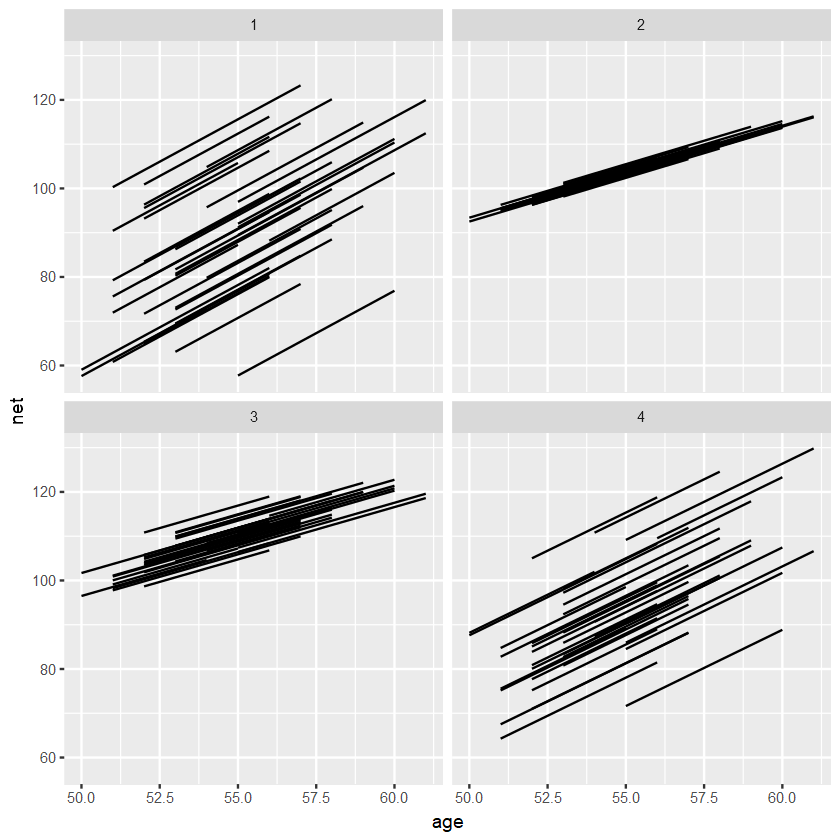

In [15]:
set.seed(84735)
running %>% 
  add_fitted_draws(running_model_1_prior, n = 4) %>%
  ggplot(aes(x = age, y = net)) +
    geom_line(aes(y = .value, group = paste(runner, .draw))) + 
    facet_wrap(~ .draw)

<br>

#### 각 시뮬레이션별 사전분포

Warning message:
"
In add_predicted_draws(): The `n` argument is a deprecated alias for `ndraws`.
Use the `ndraws` argument instead.
See help("tidybayes-deprecated").
"
Warning message:
"Removed 70 rows containing non-finite values (`stat_density()`)."


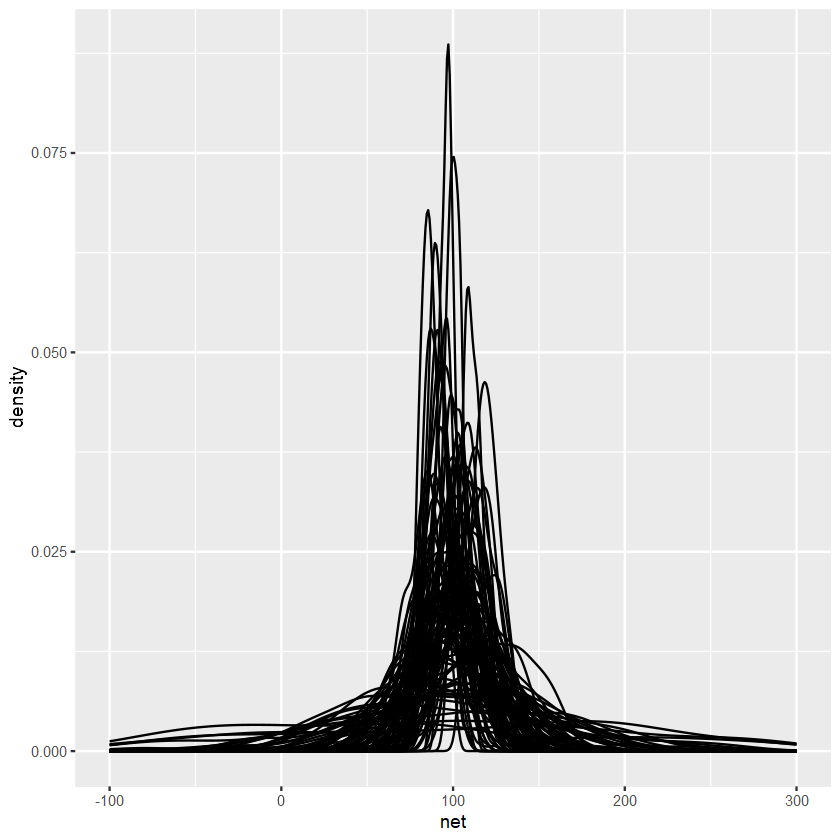

In [16]:
running %>%
  add_predicted_draws(running_model_1_prior, n = 100) %>%
  ggplot(aes(x = net)) +
    geom_density(aes(x = .prediction, group = .draw)) +
    xlim(-100,300)

<br>

### 사후분포

### autoscale된 사전분포를 통한 MCMC 시뮬레이션

In [ ]:
running_model_1 <- update(running_model_1_prior, prior_PD = FALSE)

In [22]:
# mcmc_trace(running_model_1)
# mcmc_dens_overlay(running_model_1)
# mcmc_acf(running_model_1)
# neff_ratio(running_model_1)
# rhat(running_model_1)

<br>

### 전역 매개변수별 사후분포 통계량
- `(Intercept)` : $\beta_0$
- `age` : $\beta_1$

In [49]:
as.data.frame(running_model_1) %>% head

,(Intercept),age,b[(Intercept) runner:1],b[(Intercept) runner:2],b[(Intercept) runner:3],b[(Intercept) runner:4],b[(Intercept) runner:5],b[(Intercept) runner:6],b[(Intercept) runner:7],b[(Intercept) runner:8],⋯,b[(Intercept) runner:29],b[(Intercept) runner:30],b[(Intercept) runner:31],b[(Intercept) runner:32],b[(Intercept) runner:33],b[(Intercept) runner:34],b[(Intercept) runner:35],b[(Intercept) runner:36],sigma,"Sigma[runner:(Intercept),(Intercept)]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19.16132,1.3964234,-21.28440,-9.152085,-1.9555859,4.609115,-21.23181,-20.99462,8.026467,6.612315,⋯,-36.33274,-30.80790,-7.064757,-14.71723,-11.057246,-23.65341,-11.339018,13.78862,4.538732,135.8776
2,24.38100,1.2823735,-23.75797,-7.859740,-2.7539308,6.305718,-18.46890,-19.28461,7.734496,8.229773,⋯,-29.58837,-28.76514,-6.245463,-16.26857,-12.509110,-20.78364,-11.263025,12.50708,6.370303,184.9768
3,53.82208,0.7341209,-13.61616,-9.324082,-8.0464766,6.415888,-12.87576,-24.30612,6.338929,7.764251,⋯,-33.73545,-27.54755,-12.943987,-14.72127,-10.821116,-15.80442,-6.209023,13.00187,5.619288,184.5235
4,10.16974,1.5172795,-19.88301,-8.174490,3.3473553,11.054407,-18.89073,-14.66119,13.231948,12.413884,⋯,-31.28793,-28.03474,-7.091563,-12.04552,-10.825508,-20.73534,-8.744784,13.38233,5.011140,186.3940
5,32.42259,1.1050496,-16.74482,-9.895994,-0.6967574,10.183901,-17.57612,-21.89640,10.115016,14.675397,⋯,-36.38954,-29.85827,-8.121776,-15.74609,-10.514192,-19.16254,-8.304234,15.20723,5.399652,180.5093
6,21.91273,1.2772494,-16.67670,-6.909901,-0.6450631,10.699577,-13.93766,-13.05456,15.808988,10.027399,⋯,-27.80587,-29.62287,-11.379325,-12.92896,-6.566183,-14.99461,-9.656504,15.12322,5.195008,157.9844


In [24]:
tidy_summary_1 <- tidy(running_model_1, effects = "fixed",
                       conf.int = TRUE, conf.level = 0.80)
tidy_summary_1

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),19.095972,12.3257388,3.325405,34.842915
age,1.298989,0.2203161,1.019014,1.580318


- **전역 회귀모형의 회귀선**

Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."


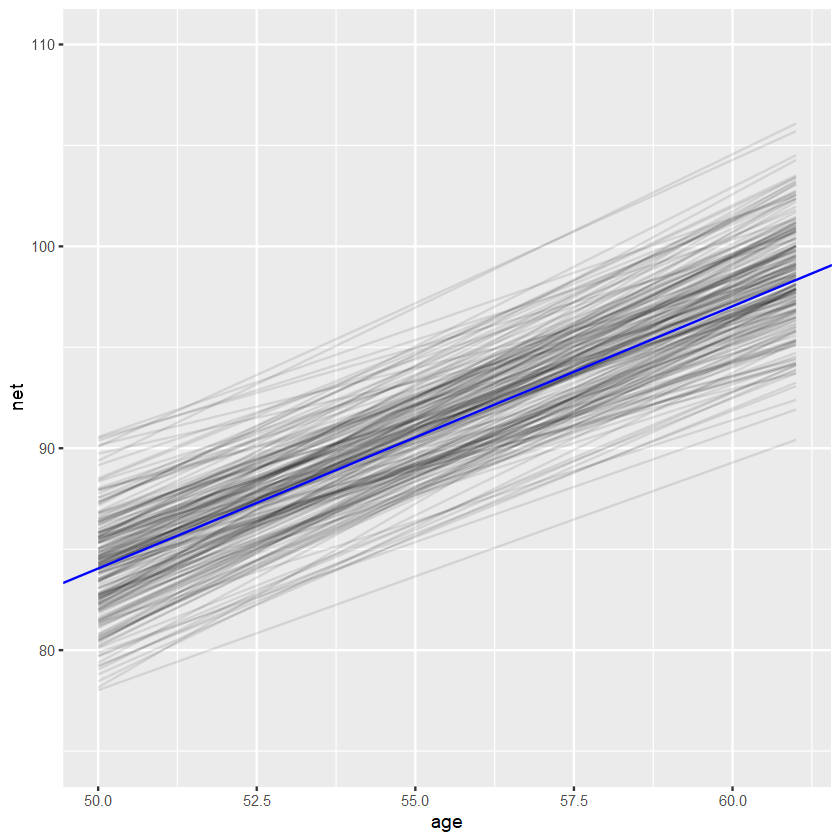

In [25]:
B0 <- tidy_summary_1$estimate[1]
B1 <- tidy_summary_1$estimate[2]

running %>%
  add_fitted_draws(running_model_1, n = 200, re_formula = NA) %>%
  ggplot(aes(x = age, y = net)) +
    geom_line(aes(y = .value, group = .draw), alpha = 0.1) +
    geom_abline(intercept = B0, slope = B1, color = "blue") +
    lims(y = c(75, 110))

<br>

### 그룹별 매개변수에 대한 사후분포
- `b[(Intercept) runner:j]` : $b_{0j} = \beta_{0j} - \beta_0$

In [48]:
as.data.frame(running_model_1) %>% head

,(Intercept),age,b[(Intercept) runner:1],b[(Intercept) runner:2],b[(Intercept) runner:3],b[(Intercept) runner:4],b[(Intercept) runner:5],b[(Intercept) runner:6],b[(Intercept) runner:7],b[(Intercept) runner:8],⋯,b[(Intercept) runner:29],b[(Intercept) runner:30],b[(Intercept) runner:31],b[(Intercept) runner:32],b[(Intercept) runner:33],b[(Intercept) runner:34],b[(Intercept) runner:35],b[(Intercept) runner:36],sigma,"Sigma[runner:(Intercept),(Intercept)]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19.16132,1.3964234,-21.28440,-9.152085,-1.9555859,4.609115,-21.23181,-20.99462,8.026467,6.612315,⋯,-36.33274,-30.80790,-7.064757,-14.71723,-11.057246,-23.65341,-11.339018,13.78862,4.538732,135.8776
2,24.38100,1.2823735,-23.75797,-7.859740,-2.7539308,6.305718,-18.46890,-19.28461,7.734496,8.229773,⋯,-29.58837,-28.76514,-6.245463,-16.26857,-12.509110,-20.78364,-11.263025,12.50708,6.370303,184.9768
3,53.82208,0.7341209,-13.61616,-9.324082,-8.0464766,6.415888,-12.87576,-24.30612,6.338929,7.764251,⋯,-33.73545,-27.54755,-12.943987,-14.72127,-10.821116,-15.80442,-6.209023,13.00187,5.619288,184.5235
4,10.16974,1.5172795,-19.88301,-8.174490,3.3473553,11.054407,-18.89073,-14.66119,13.231948,12.413884,⋯,-31.28793,-28.03474,-7.091563,-12.04552,-10.825508,-20.73534,-8.744784,13.38233,5.011140,186.3940
5,32.42259,1.1050496,-16.74482,-9.895994,-0.6967574,10.183901,-17.57612,-21.89640,10.115016,14.675397,⋯,-36.38954,-29.85827,-8.121776,-15.74609,-10.514192,-19.16254,-8.304234,15.20723,5.399652,180.5093
6,21.91273,1.2772494,-16.67670,-6.909901,-0.6450631,10.699577,-13.93766,-13.05456,15.808988,10.027399,⋯,-27.80587,-29.62287,-11.379325,-12.92896,-6.566183,-14.99461,-9.656504,15.12322,5.195008,157.9844


#### 각 그룹별 회귀모형의 절편에 대한 사후분포 통계량

In [29]:
runner_summaries_1 <- running_model_1 %>%
  spread_draws(`(Intercept)`, b[,runner]) %>% 
  mutate(runner_intercept = `(Intercept)` + b) %>% 
  select(-`(Intercept)`, -b) %>% 
  median_qi(.width = 0.80) %>% 
  select(runner, runner_intercept, .lower, .upper)

In [31]:
runner_summaries_1 %>% head

runner,runner_intercept,.lower,.upper
<chr>,<dbl>,<dbl>,<dbl>
runner:1,5.2962680,-10.309112,21.12344
runner:10,43.7404893,27.848659,59.89393
runner:11,19.3150025,3.729249,34.64918
runner:12,0.8742842,-14.724433,16.74004
runner:13,11.0727606,-4.821091,26.59165
runner:14,23.8561092,8.051633,39.74688


#### 그룹별 회귀선과, 전역 회귀선

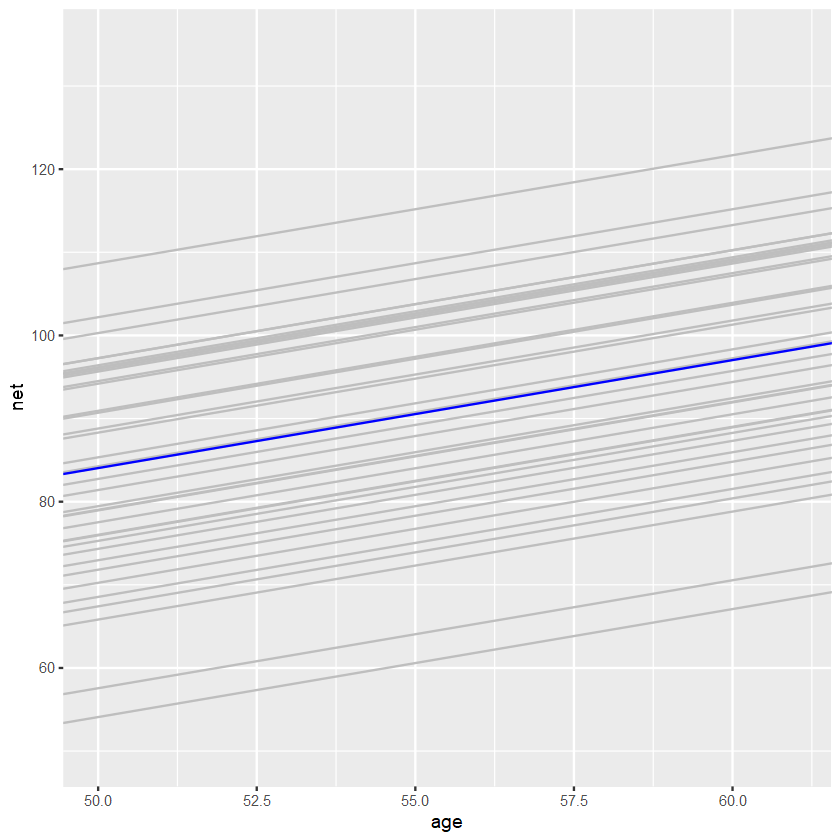

In [33]:
ggplot(running, aes(y = net, x = age, group = runner)) + 
  geom_abline(data = runner_summaries_1, color = "gray",
              aes(intercept = runner_intercept, slope = B1)) + 
  geom_abline(intercept = B0, slope = B1, color = "blue") + 
  lims(x = c(50, 61), y = c(50, 135))

<br>

### 그룹내 변동성 & 그룹간 변동성
- `sigma` : $\sigma_y$
- `Sigma[runner:(Intercept),(Intercept)]` : $\sigma_0^2$

In [47]:
as.data.frame(running_model_1) %>% head

,(Intercept),age,b[(Intercept) runner:1],b[(Intercept) runner:2],b[(Intercept) runner:3],b[(Intercept) runner:4],b[(Intercept) runner:5],b[(Intercept) runner:6],b[(Intercept) runner:7],b[(Intercept) runner:8],⋯,b[(Intercept) runner:29],b[(Intercept) runner:30],b[(Intercept) runner:31],b[(Intercept) runner:32],b[(Intercept) runner:33],b[(Intercept) runner:34],b[(Intercept) runner:35],b[(Intercept) runner:36],sigma,"Sigma[runner:(Intercept),(Intercept)]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19.16132,1.3964234,-21.28440,-9.152085,-1.9555859,4.609115,-21.23181,-20.99462,8.026467,6.612315,⋯,-36.33274,-30.80790,-7.064757,-14.71723,-11.057246,-23.65341,-11.339018,13.78862,4.538732,135.8776
2,24.38100,1.2823735,-23.75797,-7.859740,-2.7539308,6.305718,-18.46890,-19.28461,7.734496,8.229773,⋯,-29.58837,-28.76514,-6.245463,-16.26857,-12.509110,-20.78364,-11.263025,12.50708,6.370303,184.9768
3,53.82208,0.7341209,-13.61616,-9.324082,-8.0464766,6.415888,-12.87576,-24.30612,6.338929,7.764251,⋯,-33.73545,-27.54755,-12.943987,-14.72127,-10.821116,-15.80442,-6.209023,13.00187,5.619288,184.5235
4,10.16974,1.5172795,-19.88301,-8.174490,3.3473553,11.054407,-18.89073,-14.66119,13.231948,12.413884,⋯,-31.28793,-28.03474,-7.091563,-12.04552,-10.825508,-20.73534,-8.744784,13.38233,5.011140,186.3940
5,32.42259,1.1050496,-16.74482,-9.895994,-0.6967574,10.183901,-17.57612,-21.89640,10.115016,14.675397,⋯,-36.38954,-29.85827,-8.121776,-15.74609,-10.514192,-19.16254,-8.304234,15.20723,5.399652,180.5093
6,21.91273,1.2772494,-16.67670,-6.909901,-0.6450631,10.699577,-13.93766,-13.05456,15.808988,10.027399,⋯,-27.80587,-29.62287,-11.379325,-12.92896,-6.566183,-14.99461,-9.656504,15.12322,5.195008,157.9844


In [34]:
tidy_sigma <- tidy(running_model_1, effects = "ran_pars")
tidy_sigma

term,group,estimate
<chr>,<chr>,<dbl>
sd_(Intercept).runner,runner,13.316921
sd_Observation.Residual,Residual,5.247779


<br>

#### 그룹간 변동

In [35]:
sigma_0 <- tidy_sigma[1,3]
sigma_y <- tidy_sigma[2,3]
sigma_0^2 / (sigma_0^2 + sigma_y^2)

estimate
<dbl>
0.8655835


#### 그룹내 변동

In [36]:
sigma_y^2 / (sigma_0^2 + sigma_y^2)

estimate
<dbl>
0.1344165


<br>

## 17.03. 절편과 기울기에 대한 계층적 모형

### 모형 구축

$$\begin{equation}
Y_{ij} | \beta_{0j}, \beta_{1j}, \sigma_y \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ where } \mu_{ij} = \beta_{0j} + \beta_{1j} X_{ij}
\end{equation}$$

#### 각 회귀계수에 대한 사전분포

$$\begin{equation}
\beta_{0j} | \beta_0, \sigma_0 \sim N(\beta_0, \sigma_0^2)
\;\;\;\; \text{ and } \;\;\;\;
\beta_{1j} | \beta_1, \sigma_1 \sim N(\beta_1, \sigma_1^2)
\end{equation}$$**이지만, $\beta_0,\;\beta_1$은 서로 상관관계를 가지고 있기에**

$$\begin{equation}
\left(\begin{array}{c}
\beta_{0j} \\
\beta_{1j} \\
\end{array}\right) \vert 
\beta_0, \beta_1, \sigma_0, \sigma_1 
\;\; \sim \;\;
N\left( 
\left(\begin{array}{c}
\beta_0 \\
\beta_1 \\
\end{array}\right), \;
\Sigma
\right)
\end{equation}$$

#### 의 사전분포를 따름

<br>

#### 여기서 $\Sigma$는

$$\begin{equation}
\Sigma = \left(\begin{array}{cc}
\sigma_0^2 &  \rho \sigma_0 \sigma_1 \\
\rho \sigma_0 \sigma_1  & \sigma_1^2 \\
\end{array}\right)
\end{equation}$$

$$\begin{array}{rlr}
R    & = \left(\begin{array}{cc} 1 & \rho \\ \rho & 1 \end{array}\right) & \text{(1)}  \\
\tau & = \sqrt{\sigma_0^2 + \sigma_1^2} & \text{(2)}\\
\pi  & = \left(\begin{array}{c} \pi_0 \\ \pi_1 \end{array}\right) = \left(\begin{array}{c} \frac{\sigma_0^2}{\sigma_0^2 + \sigma_1^2} \\ \frac{\sigma_1^2}{\sigma_0^2 + \sigma_1^2} \end{array}\right) & \text{(3)}\\
\end{array}$$

$$\begin{split}
\left(\begin{array}{cc} \sigma_0^2 & \rho\sigma_0\sigma_1 \\ \rho\sigma_0\sigma_1 & \sigma_1^2 \end{array}\right) 
& = \left(\begin{array}{cc} \sigma_0 & 0 \\ 0 & \sigma_1 \end{array}\right) \left(\begin{array}{cc} 1 & \rho \\ \rho & 1 \end{array}\right)\left(\begin{array}{cc} \sigma_0 & 0 \\ 0 & \sigma_1 \end{array}\right)
= \text{diag}(\sigma_0, \sigma_1) \; R \; \text{diag}(\sigma_0, \sigma_1). \\
\end{split}$$

#### 로 분해되기에 ($\begin{array}{c} \sigma_0 \\ \sigma_1 \end{array}$)는

$$\left(\begin{array}{c} \sigma_0 \\ \sigma_1 \end{array}\right) = \tau \sqrt{\pi}  .$$

#### 이며, $\Sigma$는 아래 3개의 사전분포의 결합분포를 가짐

$$\begin{split}
R & \sim \text{LKJ}(\eta) \\
\tau & \sim \text{Gamma}(s, r) \\
\pi & \sim \text{Dirichlet}(2, \delta) \\
\end{split}$$



- $\rho$ : 그룹별 절편과 기울기 사이의 상관관계 
- $\sigma_0^2 + \sigma_1^2$ : 절편과 기울기가 그룹별로 달라지는 정도
- 절편과 기울기의 차이로 인해 발생하는 그룹간 변동성의 상대적 비율

$$\pi_0 = \frac{\sigma_0^2}{\sigma_0^2 + \sigma_1^2} \;\; \text{  } \;\; \pi_1 = \frac{\sigma_1^2}{\sigma_0^2 + \sigma_1^2}  .$$

$$\pi_0 + \pi_1 = \frac{\sigma_0^2}{\sigma_0^2 + \sigma_1^2} + \frac{\sigma_1^2}{\sigma_0^2 + \sigma_1^2} = 1.$$

<br>

<hr>

#### 상관행렬 $R$은 주어진 $\rho$값에 대해, $\eta > 0$를  매개변수로 가지는 $LKJ$ 사전분포를 따르며 확률분포함수는

$$f(\rho) = \left[2^{1-2\eta}\frac{\Gamma(2\eta)}{\Gamma(\eta)\Gamma(\eta)} \right] (1 - \rho^2)^{\eta - 1} \;\;\;\; \text{ for } \rho \in [-1,1] .$$

<br>

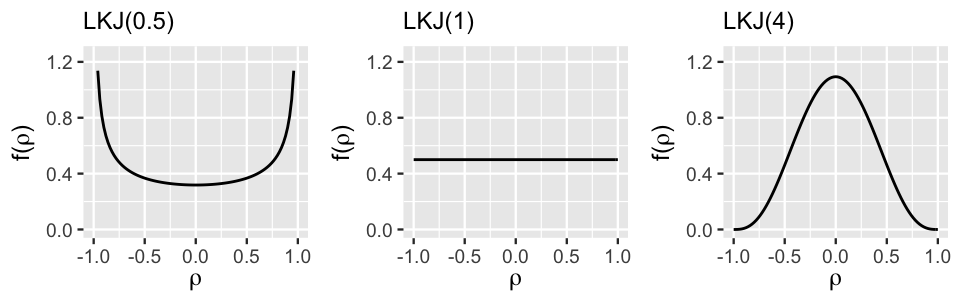

<hr>

#### $\pi=(\pi_0, \pi_1)$는 디리클레 분포 $\delta > 0$를 매개변수로 가지는 디리클레 분포를 따르며, 확률분포함수는

$$f(\pi_0,\pi_1) = \frac{\Gamma(2\delta)}{\Gamma(\delta)\Gamma(\delta)} (\pi_0 \pi_1)^{\delta - 1} \;\;\;\; \text{ for } \; \pi_0,\pi_1 \in [0,1] \; \text{ and } \; \pi_0 + \pi_1 = 1 .$$

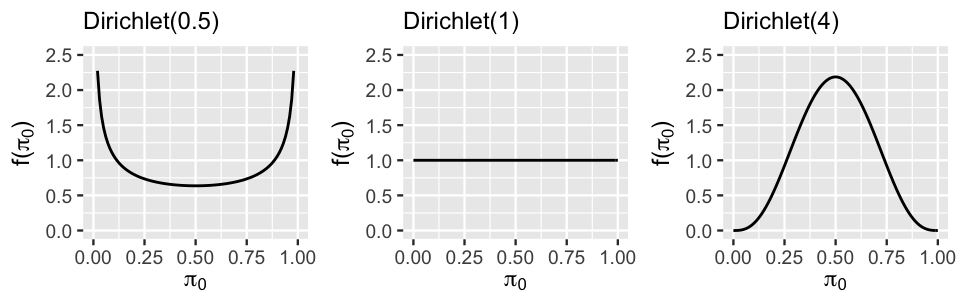

<br>


<br>

### MCMC 시뮬레이션

In [ ]:
running_model_2 <- stan_glmer(
  net ~ age + (age | runner),
  data = running, family = gaussian,
  prior_intercept = normal(100, 10),
  prior = normal(2.5, 1), 
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735, adapt_delta = 0.99999
)

In [51]:
prior_summary(running_model_2)

Priors for model 'running_model_2' 
------
Intercept (after predictors centered)
 ~ normal(location = 100, scale = 10)

Coefficients
 ~ normal(location = 2.5, scale = 1)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.072)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{array}{rl}
Y_{ij} | \beta_{0j}, \beta_{1j}, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ where } \; \mu_{ij} = \beta_{0j} + \beta_{1j} X_{ij}   \\
& \\
\left(\begin{array}{c}
\beta_{0j} \\
\beta_{1j} \\
\end{array}\right) \vert 
\beta_0, \beta_1, \sigma_0, \sigma_1 & \sim
N\left( 
\left(\begin{array}{c}
\beta_0 \\
\beta_1 \\
\end{array}\right), \;
\Sigma
\right) \\
& \\
\beta_{0c} & \sim N(100, 10^2)  \\
\beta_1 & \sim N(2.5, 1^2) \\
\sigma_y & \sim \text{Exp}(0.072)    \\
\Sigma & \sim \text{(decomposition of covariance)}. \\
\end{array}
\end{equation}$$

<br>

#### 전역 회귀모형의 절편과 기울기에 대한 사후분포 통계량

$$\beta_0 + \beta_1 X .$$

In [69]:
as.data.frame(running_model_2) %>% head

,(Intercept),age,b[(Intercept) runner:1],b[age runner:1],b[(Intercept) runner:2],b[age runner:2],b[(Intercept) runner:3],b[age runner:3],b[(Intercept) runner:4],b[age runner:4],⋯,b[(Intercept) runner:34],b[age runner:34],b[(Intercept) runner:35],b[age runner:35],b[(Intercept) runner:36],b[age runner:36],sigma,"Sigma[runner:(Intercept),(Intercept)]","Sigma[runner:age,(Intercept)]","Sigma[runner:age,age]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.789863,1.5125413,-0.8490694,-0.1944524,-1.03949670,0.04884850,0.54180373,0.147722883,-0.041638349,0.28888529,⋯,-1.745902874,-0.2227143,0.05083753,-0.005109705,-0.93990265,0.3898592,5.193737,0.54349521,-0.074885470,0.08292202
2,33.949304,0.9483416,0.3342609,-0.2387256,0.02056121,-0.04412978,-0.29029311,0.097588686,0.005387728,0.23640573,⋯,0.717712973,-0.2530680,0.01654783,0.035798656,0.29522622,0.3671037,5.009914,0.07237294,0.009333941,0.04488630
3,31.241739,1.0490120,-0.8450759,-0.2394907,-0.71147259,-0.09070600,1.41947515,0.007245948,-1.461998214,0.23707023,⋯,-0.825279845,-0.2623048,0.83557719,-0.023478244,0.72134161,0.3394279,4.887564,1.20032493,-0.015136909,0.06018925
4,5.901051,1.4776083,2.0782866,-0.2811844,1.38637364,-0.07843062,-0.50795288,0.124905222,2.238049000,0.25134831,⋯,1.548681489,-0.2881786,-1.15375907,0.013554260,-1.51100886,0.4222300,5.277594,3.13692354,-0.157701530,0.06994814
5,23.610671,1.2669216,0.1214803,-0.3493399,0.05279546,-0.17894447,-0.03885056,-0.010742025,-0.646626324,0.08236123,⋯,0.007873019,-0.3233588,0.06914012,-0.051047971,-0.08142493,0.2809137,5.356232,0.20820638,-0.022276345,0.04220130
6,17.102603,1.3227295,0.4638660,-0.1492478,0.36204681,-0.05783997,-0.03250285,0.018589300,-0.190085048,0.26723840,⋯,0.527084510,-0.2315784,-0.07575414,-0.099535931,-0.68456858,0.3491770,5.177668,0.59527526,-0.069710768,0.04360916


In [52]:
tidy(running_model_2, effects = "fixed", conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),18.529489,11.7780669,3.378999,33.746525
age,1.316018,0.2171766,1.034441,1.594853


<br>

#### 그룹별 회귀모형의 절편과 기울기에 대한 사후분포 통계량

$$\beta_{0j} = \beta_0 + b_{0j}$$

In [70]:
as.data.frame(running_model_2) %>% head

,(Intercept),age,b[(Intercept) runner:1],b[age runner:1],b[(Intercept) runner:2],b[age runner:2],b[(Intercept) runner:3],b[age runner:3],b[(Intercept) runner:4],b[age runner:4],⋯,b[(Intercept) runner:34],b[age runner:34],b[(Intercept) runner:35],b[age runner:35],b[(Intercept) runner:36],b[age runner:36],sigma,"Sigma[runner:(Intercept),(Intercept)]","Sigma[runner:age,(Intercept)]","Sigma[runner:age,age]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.789863,1.5125413,-0.8490694,-0.1944524,-1.03949670,0.04884850,0.54180373,0.147722883,-0.041638349,0.28888529,⋯,-1.745902874,-0.2227143,0.05083753,-0.005109705,-0.93990265,0.3898592,5.193737,0.54349521,-0.074885470,0.08292202
2,33.949304,0.9483416,0.3342609,-0.2387256,0.02056121,-0.04412978,-0.29029311,0.097588686,0.005387728,0.23640573,⋯,0.717712973,-0.2530680,0.01654783,0.035798656,0.29522622,0.3671037,5.009914,0.07237294,0.009333941,0.04488630
3,31.241739,1.0490120,-0.8450759,-0.2394907,-0.71147259,-0.09070600,1.41947515,0.007245948,-1.461998214,0.23707023,⋯,-0.825279845,-0.2623048,0.83557719,-0.023478244,0.72134161,0.3394279,4.887564,1.20032493,-0.015136909,0.06018925
4,5.901051,1.4776083,2.0782866,-0.2811844,1.38637364,-0.07843062,-0.50795288,0.124905222,2.238049000,0.25134831,⋯,1.548681489,-0.2881786,-1.15375907,0.013554260,-1.51100886,0.4222300,5.277594,3.13692354,-0.157701530,0.06994814
5,23.610671,1.2669216,0.1214803,-0.3493399,0.05279546,-0.17894447,-0.03885056,-0.010742025,-0.646626324,0.08236123,⋯,0.007873019,-0.3233588,0.06914012,-0.051047971,-0.08142493,0.2809137,5.356232,0.20820638,-0.022276345,0.04220130
6,17.102603,1.3227295,0.4638660,-0.1492478,0.36204681,-0.05783997,-0.03250285,0.018589300,-0.190085048,0.26723840,⋯,0.527084510,-0.2315784,-0.07575414,-0.099535931,-0.68456858,0.3491770,5.177668,0.59527526,-0.069710768,0.04360916


In [53]:
runner_chains_2 <- running_model_2 %>%
  spread_draws(`(Intercept)`, b[term, runner], `age`) %>% 
  pivot_wider(names_from = term, names_glue = "b_{term}",
              values_from = b) %>% 
  mutate(runner_intercept = `(Intercept)` + `b_(Intercept)`,
         runner_age = age + b_age)

In [54]:
runner_summaries_2 <- runner_chains_2 %>% 
  group_by(runner) %>% 
  summarize(runner_intercept = median(runner_intercept),
            runner_age = median(runner_age))

In [55]:
head(runner_summaries_2, 3)

runner,runner_intercept,runner_age
<chr>,<dbl>,<dbl>
runner:1,18.53214,1.058145
runner:10,18.49374,1.751762
runner:11,18.51161,1.315841


- **각 그룹별 회귀선은, 전역 회귀선과 큰 차이를 보이지 않으며 이는 수축에 의한 것**

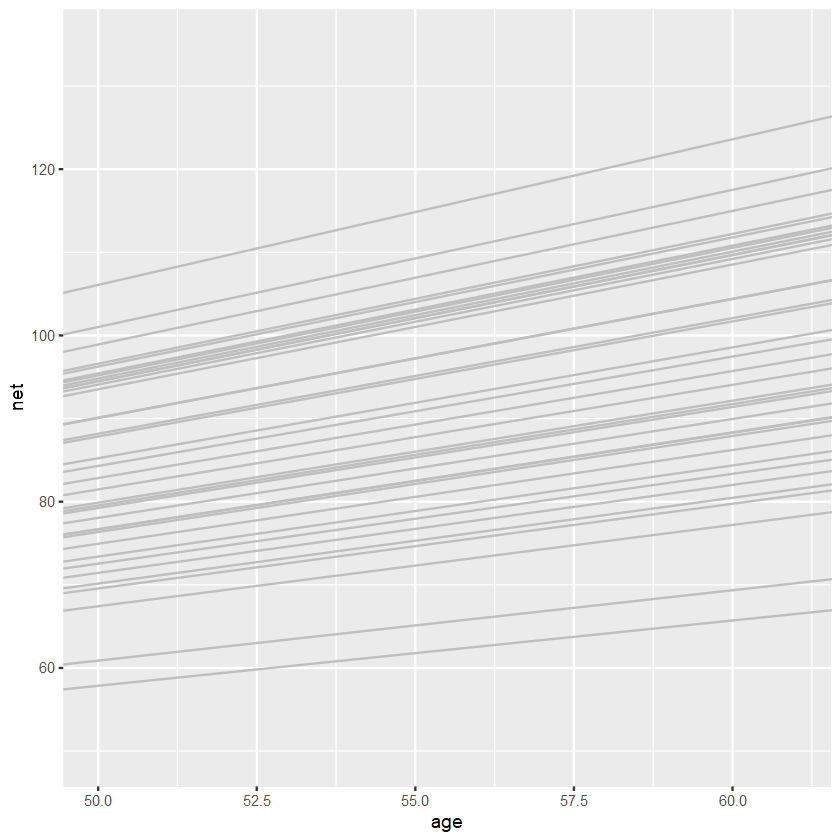

In [56]:
ggplot(running, aes(y = net, x = age, group = runner)) + 
  geom_abline(data = runner_summaries_2, color = "gray",
              aes(intercept = runner_intercept, slope = runner_age)) + 
  lims(x = c(50, 61), y = c(50, 135))

<br>

#### 그룹내 변동성, 그룹간 변동성
- $σ_y$ : `sd_Observation.Residual`
- $ρ$ : `cor_(Intercept).age.runner`
- $σ_0$ : `sd_(Intercept).runner`
- $σ_1$ : `sd_age.runner`

In [73]:
as.data.frame(running_model_2) %>% head

,(Intercept),age,b[(Intercept) runner:1],b[age runner:1],b[(Intercept) runner:2],b[age runner:2],b[(Intercept) runner:3],b[age runner:3],b[(Intercept) runner:4],b[age runner:4],⋯,b[(Intercept) runner:34],b[age runner:34],b[(Intercept) runner:35],b[age runner:35],b[(Intercept) runner:36],b[age runner:36],sigma,"Sigma[runner:(Intercept),(Intercept)]","Sigma[runner:age,(Intercept)]","Sigma[runner:age,age]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.789863,1.5125413,-0.8490694,-0.1944524,-1.03949670,0.04884850,0.54180373,0.147722883,-0.041638349,0.28888529,⋯,-1.745902874,-0.2227143,0.05083753,-0.005109705,-0.93990265,0.3898592,5.193737,0.54349521,-0.074885470,0.08292202
2,33.949304,0.9483416,0.3342609,-0.2387256,0.02056121,-0.04412978,-0.29029311,0.097588686,0.005387728,0.23640573,⋯,0.717712973,-0.2530680,0.01654783,0.035798656,0.29522622,0.3671037,5.009914,0.07237294,0.009333941,0.04488630
3,31.241739,1.0490120,-0.8450759,-0.2394907,-0.71147259,-0.09070600,1.41947515,0.007245948,-1.461998214,0.23707023,⋯,-0.825279845,-0.2623048,0.83557719,-0.023478244,0.72134161,0.3394279,4.887564,1.20032493,-0.015136909,0.06018925
4,5.901051,1.4776083,2.0782866,-0.2811844,1.38637364,-0.07843062,-0.50795288,0.124905222,2.238049000,0.25134831,⋯,1.548681489,-0.2881786,-1.15375907,0.013554260,-1.51100886,0.4222300,5.277594,3.13692354,-0.157701530,0.06994814
5,23.610671,1.2669216,0.1214803,-0.3493399,0.05279546,-0.17894447,-0.03885056,-0.010742025,-0.646626324,0.08236123,⋯,0.007873019,-0.3233588,0.06914012,-0.051047971,-0.08142493,0.2809137,5.356232,0.20820638,-0.022276345,0.04220130
6,17.102603,1.3227295,0.4638660,-0.1492478,0.36204681,-0.05783997,-0.03250285,0.018589300,-0.190085048,0.26723840,⋯,0.527084510,-0.2315784,-0.07575414,-0.099535931,-0.68456858,0.3491770,5.177668,0.59527526,-0.069710768,0.04360916


In [57]:
tidy(running_model_2, effects = "ran_pars")

term,group,estimate
<chr>,<chr>,<dbl>
sd_(Intercept).runner,runner,1.3052311
sd_age.runner,runner,0.2510133
cor_(Intercept).age.runner,runner,-0.1097985
sd_Observation.Residual,Residual,5.1671664


<br>

## 17.04. 모형 평가

#### 완전풀링

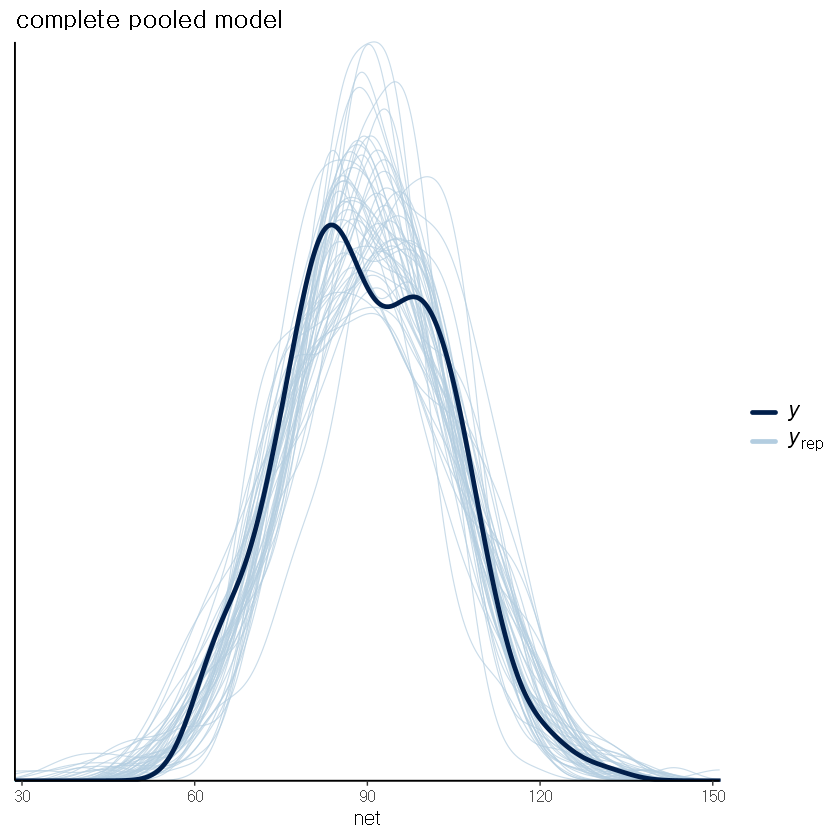

In [65]:
pp_check(complete_pooled_model) + 
  labs(x = "net", title = "complete pooled model")

#### 절편만 고려하는 모형

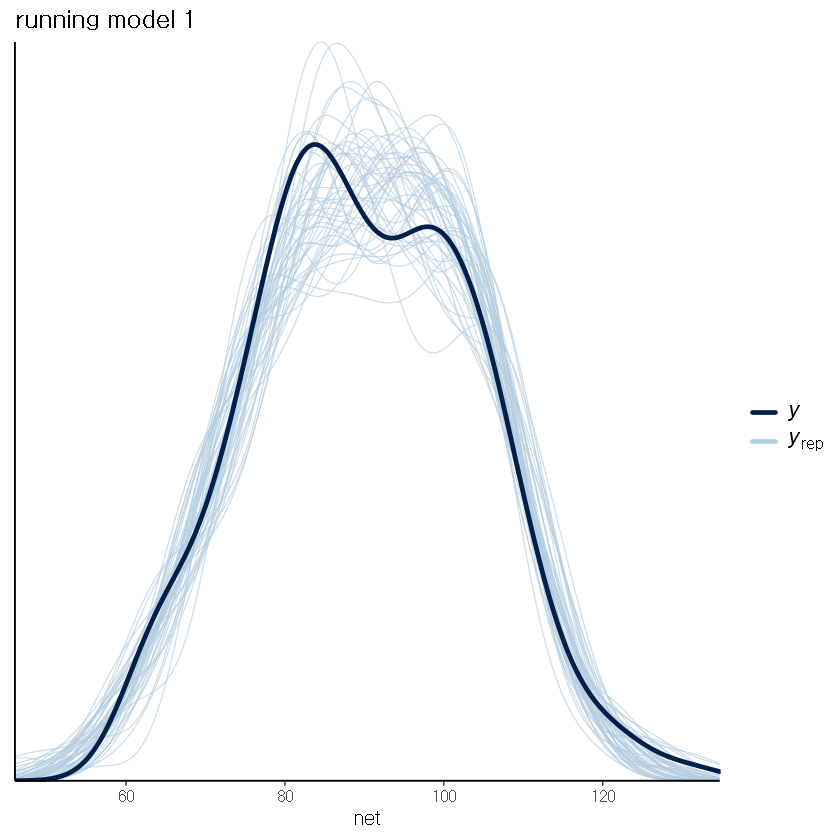

In [66]:
pp_check(running_model_1) + 
  labs(x = "net", title = "running model 1")

#### 절편과 기울기 모두를 고려하는 모형

In [ ]:
pp_check(running_model_2) + 
  labs(x = "net", title = "running model 2")

<br>


In [60]:
set.seed(84735)
prediction_summary(model = running_model_1, data = running)

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
2.623623,0.4521105,0.6864865,0.972973


In [59]:
prediction_summary(model = running_model_2, data = running)

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
2.481462,0.4380704,0.7027027,0.972973


<br>

#### 교차검증

In [61]:
prediction_summary_cv(model = running_model_1, data = running,
                      k = 10, group = "runner")

fold,mae,mae_scaled,within_50,within_95
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,16.804363,1.1534521,0.2857143,1.0000000
2,8.782570,0.6074914,0.5652174,0.7826087
3,10.844425,0.7461143,0.3571429,1.0000000
4,8.049585,0.5717555,0.5000000,0.7000000
5,15.244342,1.0527954,0.1111111,1.0000000
6,11.807641,0.8249542,0.3571429,0.8571429
7,10.641272,0.7226662,0.3333333,1.0000000
8,12.327708,0.8412997,0.4117647,1.0000000
9,5.909503,0.4061942,0.7272727,0.9545455


<br>

#### ELPD를 통한 비교

In [67]:
elpd_hierarchical_1 <- loo(running_model_1)
elpd_hierarchical_2 <- loo(running_model_2)

loo_compare(elpd_hierarchical_1, elpd_hierarchical_2)

Warning message:
"Found 1 observation(s) with a pareto_k > 0.7. We recommend calling 'loo' again with argument 'k_threshold = 0.7' in order to calculate the ELPD without the assumption that these observations are negligible. This will refit the model 1 times to compute the ELPDs for the problematic observations directly.
"
Warning message:
"Found 1 observation(s) with a pareto_k > 0.7. We recommend calling 'loo' again with argument 'k_threshold = 0.7' in order to calculate the ELPD without the assumption that these observations are negligible. This will refit the model 1 times to compute the ELPDs for the problematic observations directly.
"


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
running_model_2,0.000000,0.000000,-588.0030,17.29358,36.43586,6.630368,1176.006,34.58716
running_model_1,-1.463182,1.249697,-589.4662,17.02235,35.91727,6.449559,1178.932,34.04470


<br>

## 17.05. 사후예측분포

#### 새로운 그룹 `Miles`에서, `age`=61일 때 사후예측분포

In [63]:
set.seed(84735)
predict_next_race <- posterior_predict(
  running_model_1, 
  newdata = data.frame(runner = c("1", "Miles", "10"),
                       age = c(61, 61, 61)))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


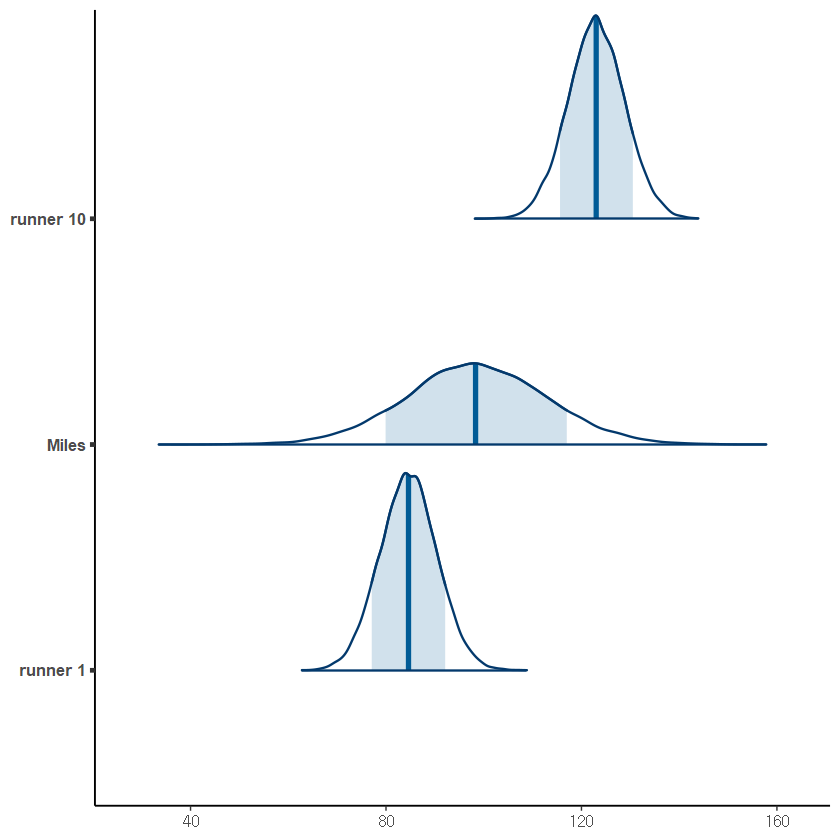

In [64]:
mcmc_areas(predict_next_race, prob = 0.8) +
 ggplot2::scale_y_discrete(labels = c("runner 1", "Miles", "runner 10"))

<br>

## 17.06. Spotify 예제

In [ ]:
spotify_model_1 <- stan_glmer(
  danceability ~ valence + genre + (1 | artist),
  data = spotify, family = gaussian,
  prior_intercept = normal(50, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735)

In [76]:
prior_summary(spotify_model_1)

Priors for model 'spotify_model_1' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 50, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 50, scale = 37)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0,...], scale = [2.5,2.5,2.5,...])
  Adjusted prior:
    ~ normal(location = [0,0,0,...], scale = [  1.71,138.94, 92.19,...])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.067)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

<br>

In [ ]:
spotify_model_2 <- stan_glmer(
  danceability ~ valence + genre + (valence | artist), 
  data = spotify, family = gaussian,
  prior_intercept = normal(50, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735)

In [78]:
prior_summary(spotify_model_2)

Priors for model 'spotify_model_2' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 50, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 50, scale = 37)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0,...], scale = [2.5,2.5,2.5,...])
  Adjusted prior:
    ~ normal(location = [0,0,0,...], scale = [  1.71,138.94, 92.19,...])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.067)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

<br>

#### 사후분포 검사

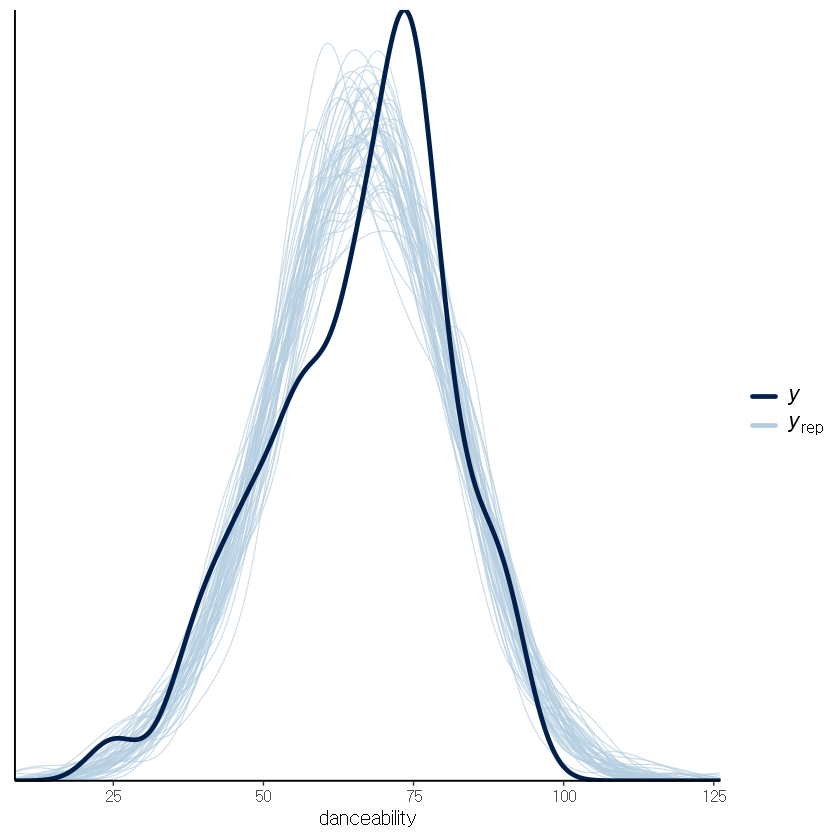

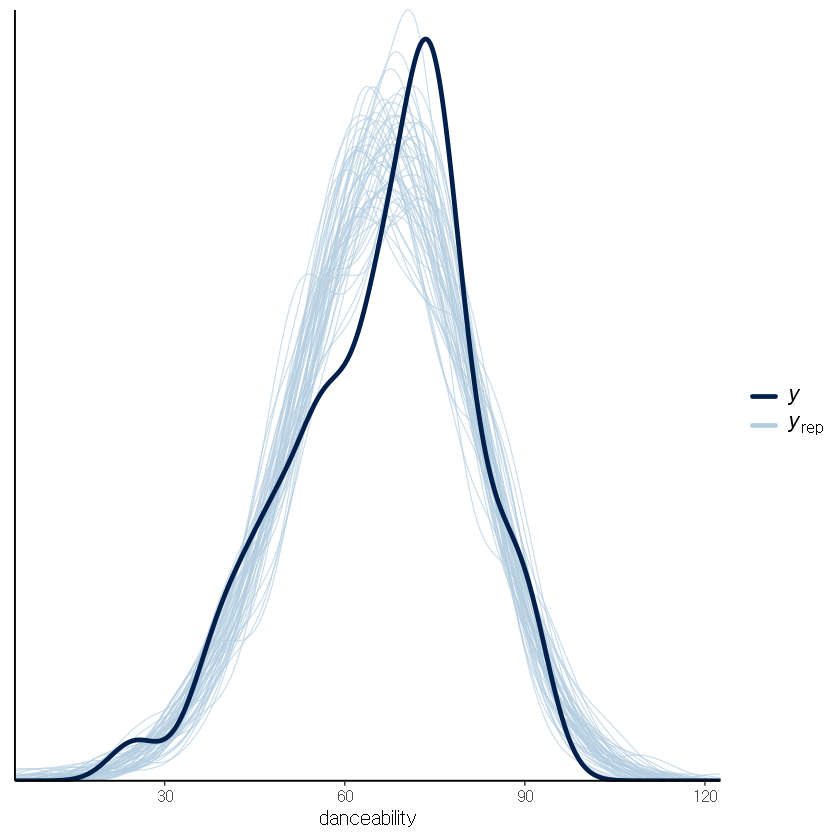

In [79]:
pp_check(spotify_model_1) +
  xlab("danceability")

pp_check(spotify_model_2) +
  xlab("danceability")

<br>

#### 사후분포 통계량

In [80]:
tidy(spotify_model_1, effects = "fixed",
     conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),53.2595910,3.0621185,49.3534620,57.1775777
valence,0.2578836,0.0325262,0.2159092,0.3006995
genrelatin,0.3988208,3.5517810,-4.1089442,4.9503897
genrepop,0.4840303,2.6396240,-2.9450284,3.8847140
genrer&b,-2.3699192,2.8454059,-6.0519329,1.2853068
genrerap,1.6814657,3.1476293,-2.3245434,5.6943155
genrerock,-6.6799177,4.2024836,-12.0573009,-1.3728389


In [88]:
tidy(spotify_model_2, effects = "fixed",
     conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),53.4195367,3.60386194,48.8284496,57.9879090
valence,0.2452141,0.04122218,0.1914226,0.2962799
genrelatin,1.5882752,3.47672359,-2.9452070,5.9680321
genrepop,1.3392661,2.69679917,-2.1833170,4.6906882
genrer&b,-0.9778749,2.87392140,-4.6716295,2.7401678
genrerap,2.0517383,3.10841328,-1.8769863,5.9924351
genrerock,-6.6757184,4.08999409,-11.8392283,-1.3498316


<br>

#### 사후예측분포

In [82]:
set.seed(84735)
predict_next_song <- posterior_predict(
  spotify_model_1,
  newdata = data.frame(
    artist = c("Camilo", "Mohsen Beats", "Missy Elliott"), 
    valence = c(80, 60, 90), genre = c("latin", "rock", "rap")))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


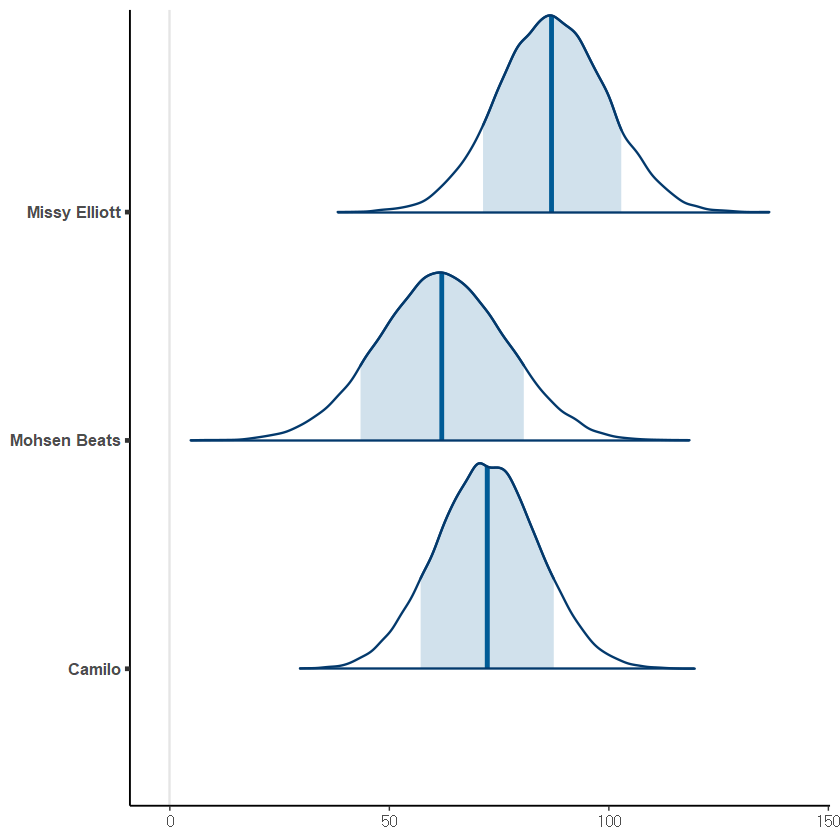

In [83]:
mcmc_areas(predict_next_song, prob = 0.8) +
 ggplot2::scale_y_discrete(
   labels = c("Camilo", "Mohsen Beats", "Missy Elliott"))

In [89]:
set.seed(84735)
predict_next_song <- posterior_predict(
  spotify_model_2,
  newdata = data.frame(
    artist = c("Camilo", "Mohsen Beats", "Missy Elliott"), 
    valence = c(80, 60, 90), genre = c("latin", "rock", "rap")))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


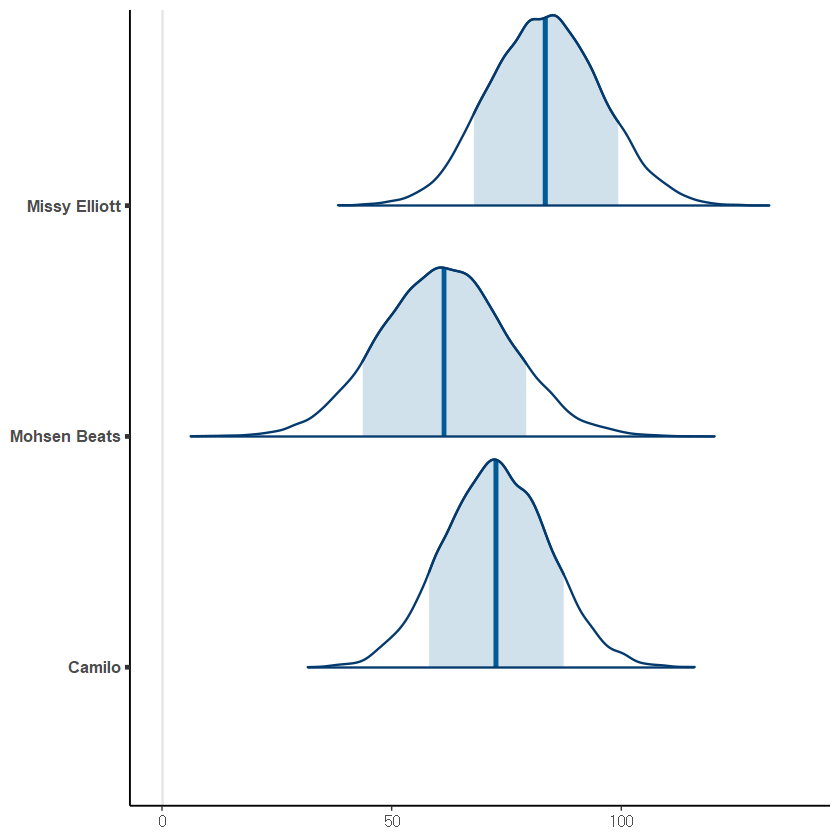

In [90]:
mcmc_areas(predict_next_song, prob = 0.8) +
 ggplot2::scale_y_discrete(
   labels = c("Camilo", "Mohsen Beats", "Missy Elliott"))